# Laboratorium 5 - Zespoły klasyfikatorów

In [43]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report


from sklearn.ensemble import RandomForestClassifier,\
    HistGradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import optuna


# Later for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

import yaml
with open('params.yaml', 'r') as file:
    vars = yaml.safe_load(file)

## 1. Wczytanie danych, info o datasecie (eng)

In [21]:
raw_df = pd.read_csv('data/churn_prediction.csv')
raw_df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
1,2,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
2,4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
3,5,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
4,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03


The churn prediction dataset, which contains raw data of 28,382 customers. The dataset includes the following columns:

* customer_id: Unique identifier for each customer.
* vintage: The duration of the customer's relationship with the company.
* age: Age of the customer.
* gender: Gender of the customer.
* dependents: Number of dependents the customer has.
* occupation: The occupation of the customer.
* city: City in which the customer is located.
* customer_nw_category: Net worth category of the customer.
* branch_code: Code identifying the branch associated with the customer.
* current_balance: Current balance in the customer's account.
* previous_month_end_balance: Account balance at the end of the previous month.
* average_monthly_balance_prevQ: Average monthly balance in the previous quarter.
* average_monthly_balance_prevQ2: Average monthly balance in the second previous quarter.
* current_month_credit: Credit amount in the current month.
* previous_month_credit: Credit amount in the previous month.
* current_month_debit: Debit amount in the current month.
* previous_month_debit: Debit amount in the previous month.
* current_month_balance: Account balance in the current month.
* previous_month_balance: Account balance in the previous month.
* churn: The target variable indicating whether the customer has churned (1 for churned, 0 for not churned).
* last_transaction: Timestamp of the customer's last transaction.

This dataset provides a comprehensive view of various attributes related to the customers' banking activities. With these features, it becomes possible to build predictive models to identify potential churners based on historical and current customer behavior. The dataset's size allows for robust analysis and modeling to improve customer retention strategies.

[Źródło: www.kaggle.com](https://www.kaggle.com/datasets/pentakrishnakishore/bank-customer-churn-data)

In [22]:
raw_df.shape

(28382, 21)

In [23]:
def basic_info(df: pd.DataFrame) -> pd.DataFrame:
    basic_info = pd.DataFrame(data = {'dtype': df.dtypes.values, 
                                    'nunique': df.nunique().values,
                                    'missing values': (round((df.isna().sum() / len(df)) * 100, 2).astype(str) + '%').values})
    basic_info.set_index(df.columns, inplace = True)
    return basic_info

basic_info(raw_df)

,dtype,nunique,missing values
customer_id,int64,28382,0.0%
vintage,int64,1459,0.0%
age,int64,90,0.0%
gender,object,2,1.85%
dependents,float64,15,8.68%
occupation,object,5,0.28%
city,float64,1604,2.83%
customer_nw_category,int64,3,0.0%
branch_code,int64,3185,0.0%
current_balance,float64,27903,0.0%


Szybkie wnioski:
* Nie potrzebna nam kolumna customer_id. Usuniemy ją.
* Kolumnę **dependents** zmienimy na typ int
* Kolumny z danymi kategorycznymi zmienimy na typ categorical
* Dokonamy preprocessingu kolumny z datą

## 2. Preprocessing 1

### Zmiana typów danych

In [24]:
def dtypes_preprocessing(df: pd.DataFrame = raw_df) -> pd.DataFrame:
    df_copy = deepcopy(df)
    # Drop customer_id
    df_copy.drop(['customer_id'], axis = 1, inplace = True)
    # Categoricals
    cats = ['dependents', 'branch_code', 'customer_nw_category', 'churn', 'city', 'gender', 'occupation']
    for cat in cats:
        df_copy[cat] = df_copy[cat].astype('category')
    # Date
    date = pd.DatetimeIndex(df_copy['last_transaction'])
    df_copy['year'] = date.year.astype('Int64').astype('category')
    df_copy['month'] = date.month.astype('Int64').astype('category')
    df_copy['day'] = date.day.astype('Int64').astype('category')
    df_copy['weekday'] = date.day_name().astype('category')
    df_copy.drop(['last_transaction'], axis = 1, inplace = True)
    
    del df
    
    return df_copy


df_processed_dtypes = dtypes_preprocessing()
df_processed_dtypes.head()

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,year,month,day,weekday
0,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019,5,21,Tuesday
1,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019,11,1,Friday
2,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaN,NaN,NaN,NaN
3,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019,8,6,Tuesday
4,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019,11,3,Sunday


### Podział na zbiory treningowy i testowy

In [25]:
def split_data(df: pd.DataFrame = df_processed_dtypes, random_state: int = vars['params']['random_state']) -> tuple[pd.DataFrame, pd.DataFrame]:
    train, test = train_test_split(df, 
                                shuffle = True, 
                                stratify = df['churn'], 
                                random_state = random_state)
    train = train.reset_index(drop = True)
    test = test.reset_index(drop = True)
    train.to_csv('data/train.csv', index=False)
    test.to_csv('data/test.csv', index=False)
    
    return train, test

train_df, test_df = split_data()

In [26]:
display(len(train_df))
train_df.head(2)

21286

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,year,month,day,weekday
0,1782,45,Female,0.0,self_employed,797.0,2,1631,15485.43,6771.15,10702.23,15336.69,35714.46,1428.74,27571.6,6444.40,18495.28,7719.67,0,2019,12,18,Wednesday
1,2125,34,Male,2.0,salaried,168.0,2,3395,1028.11,1437.06,1437.03,277.55,0.01,0.01,480.4,733.33,1092.28,1610.02,1,2019,10,22,Tuesday


In [27]:
display(len(test_df))
train_df.head(2)

7096

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,year,month,day,weekday
0,1782,45,Female,0.0,self_employed,797.0,2,1631,15485.43,6771.15,10702.23,15336.69,35714.46,1428.74,27571.6,6444.40,18495.28,7719.67,0,2019,12,18,Wednesday
1,2125,34,Male,2.0,salaried,168.0,2,3395,1028.11,1437.06,1437.03,277.55,0.01,0.01,480.4,733.33,1092.28,1610.02,1,2019,10,22,Tuesday


## 3. EDA

In [28]:
df = train_df

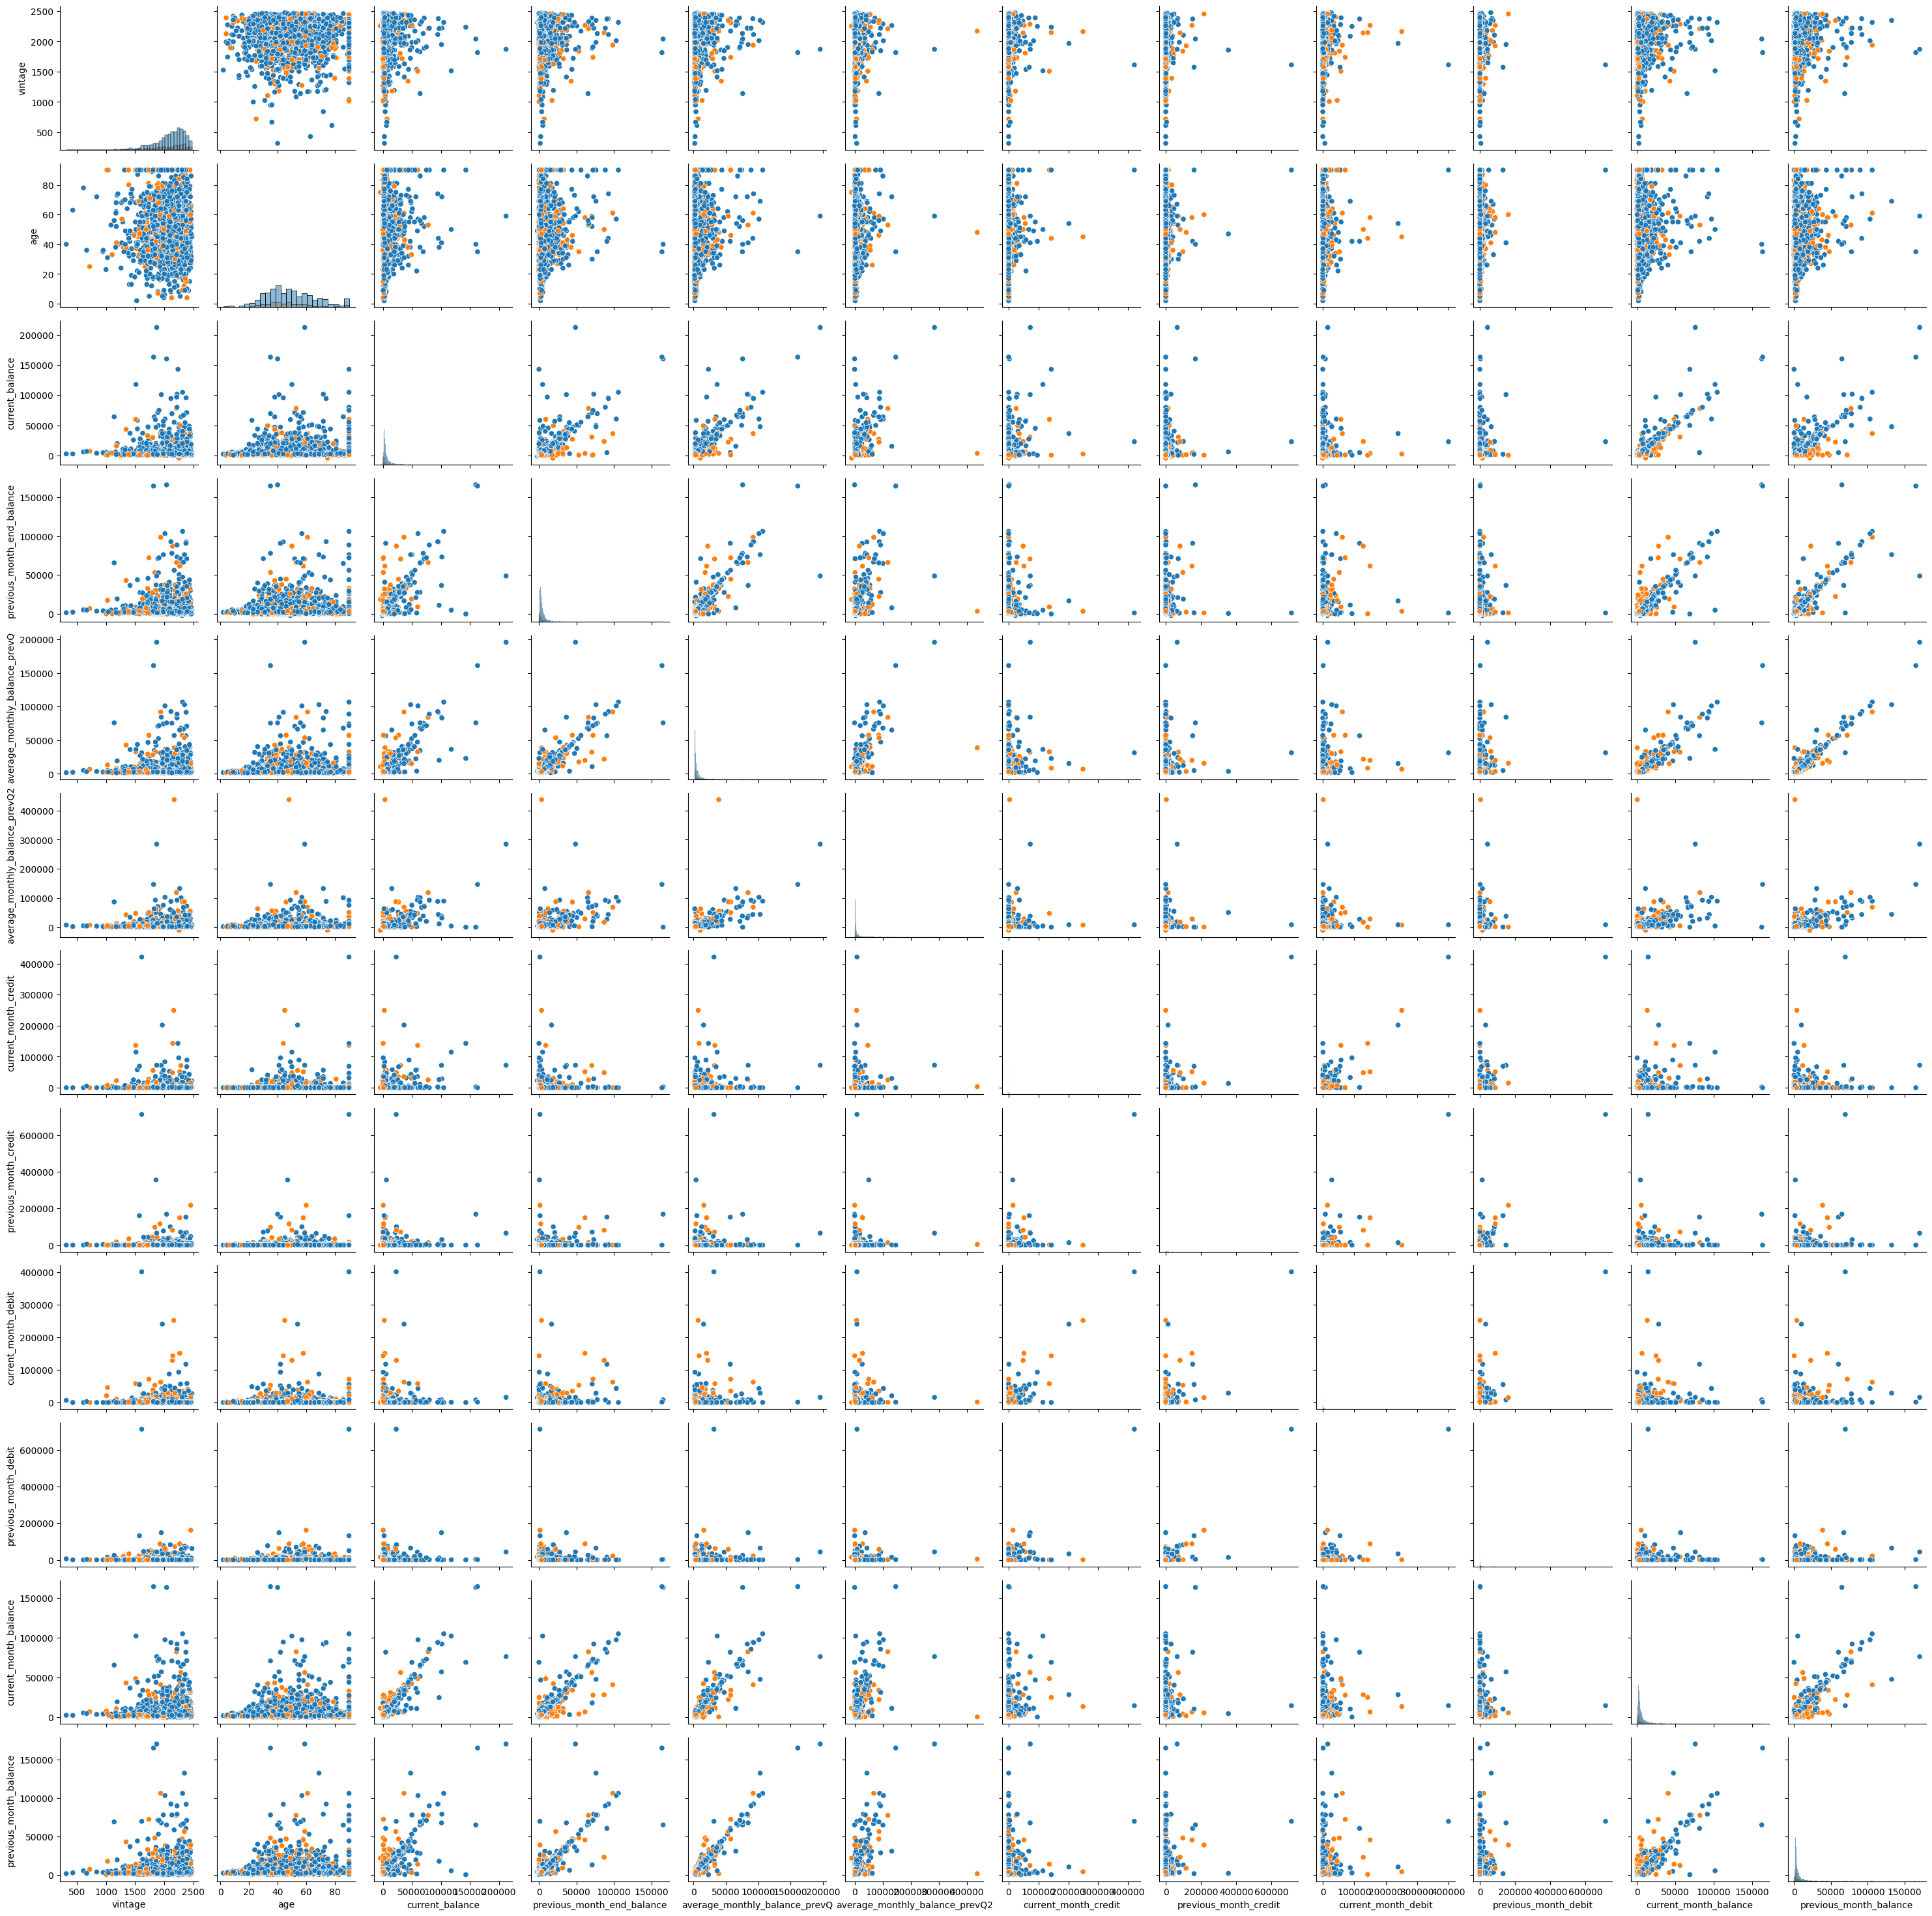

In [29]:
def visualize_nums(df: pd.DataFrame = df, samples: int = 2000) -> None:

    x_vars = df.select_dtypes(include = 'number').columns
    df_copy = deepcopy(df.sample(n = samples, random_state = vars['params']['random_state']))
    g = sns.PairGrid(df_copy, hue = 'churn', x_vars = x_vars, y_vars = x_vars)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    plt.show()
    
    del df_copy
    
visualize_nums()

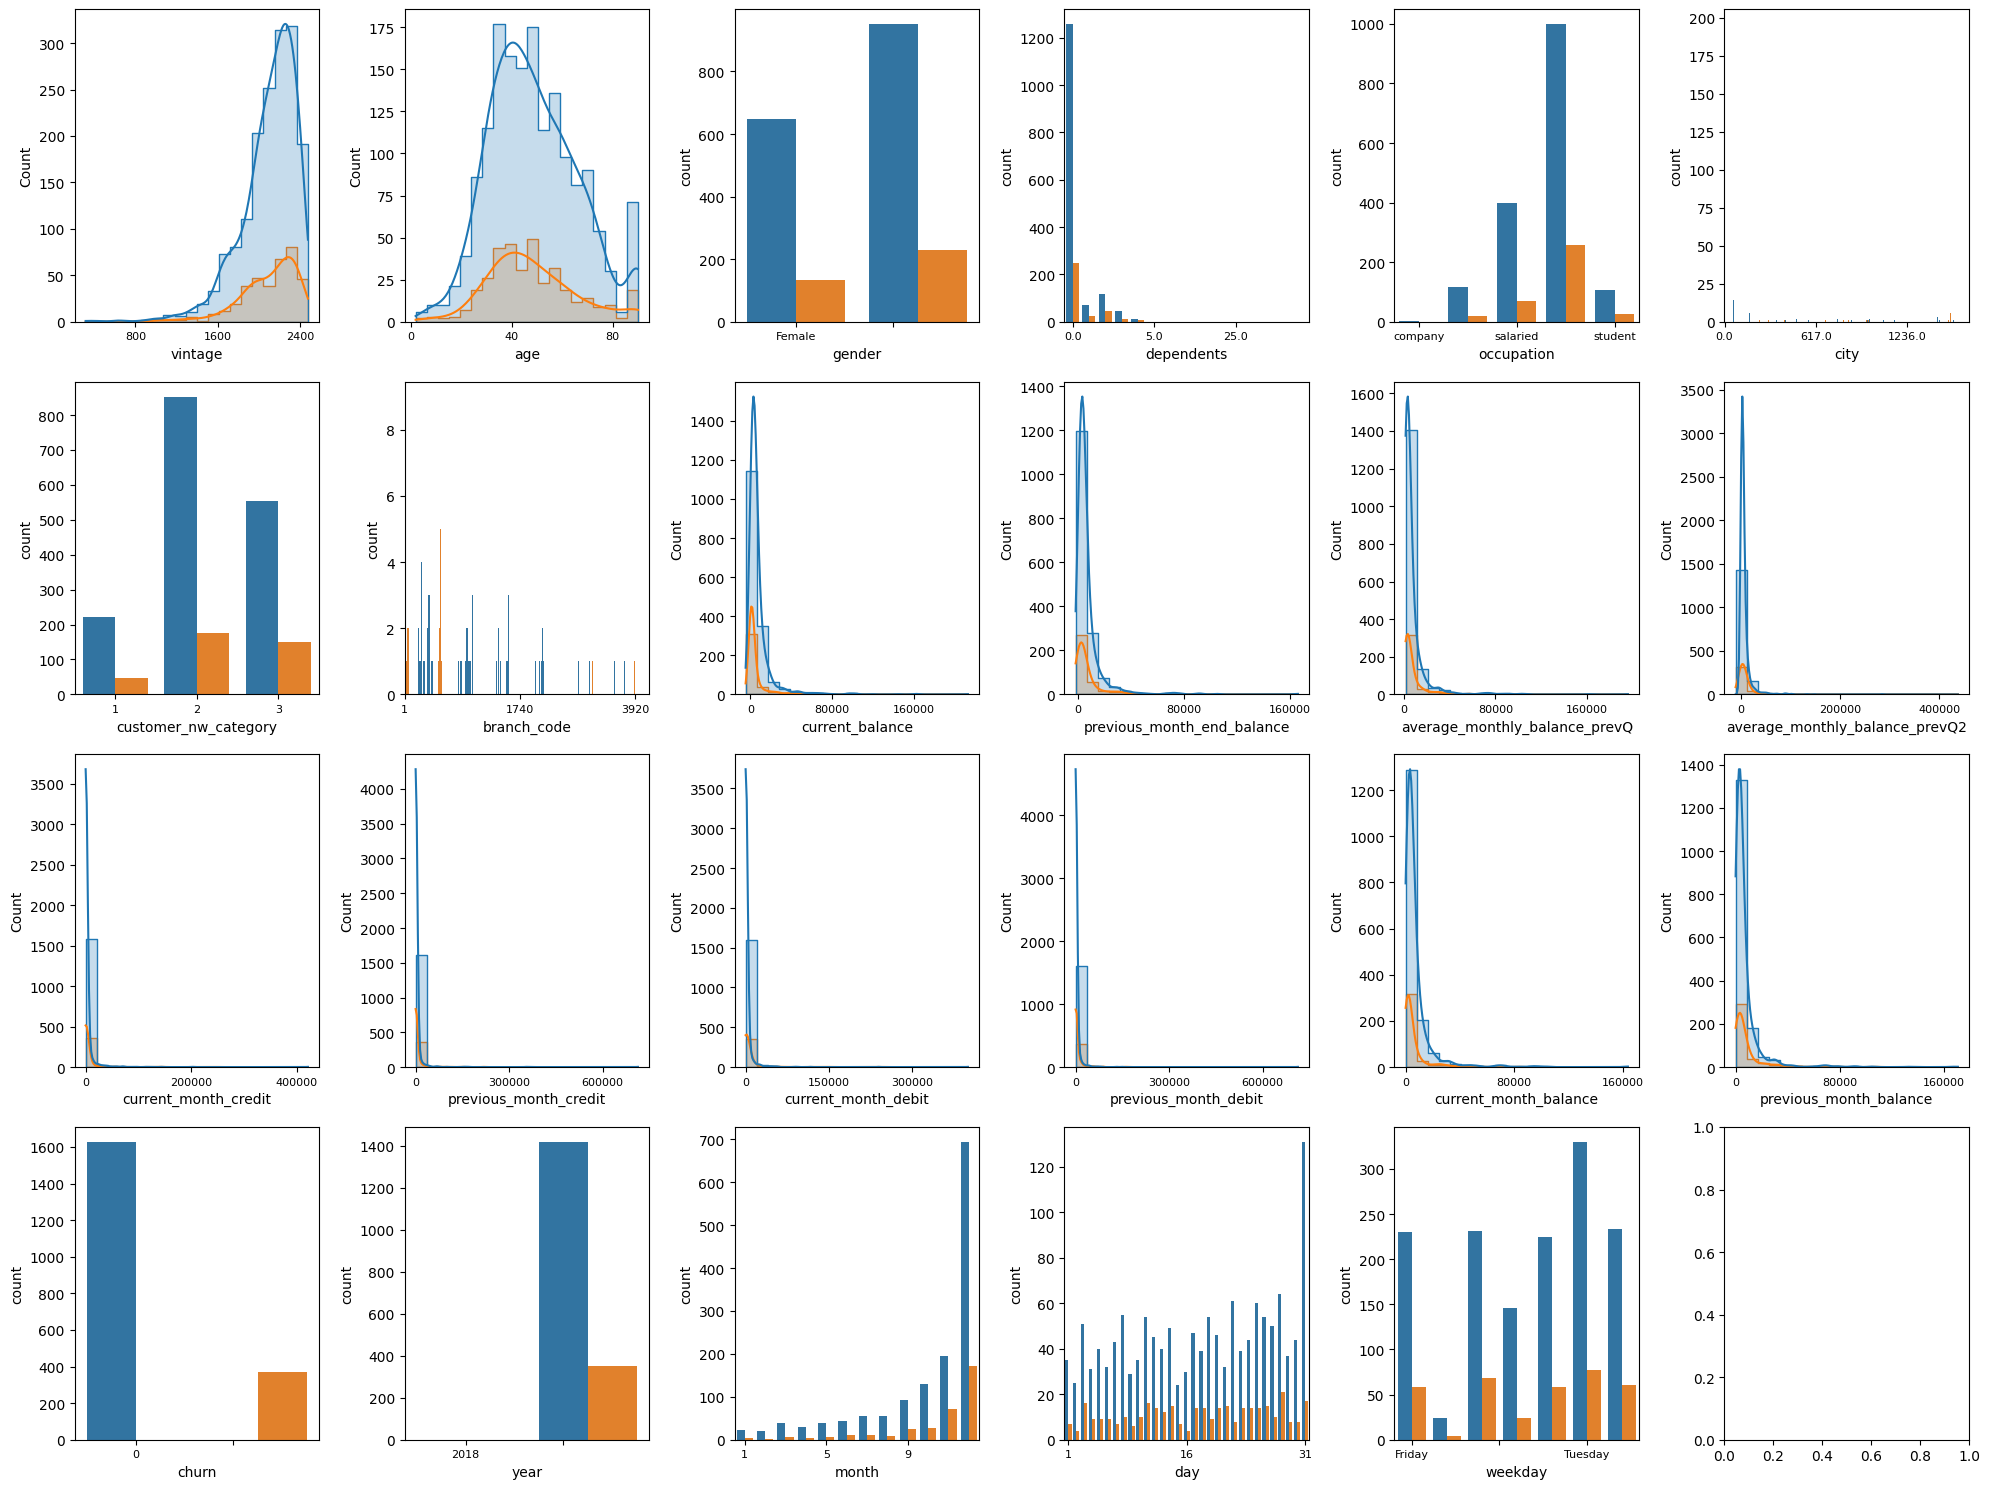

In [30]:
def vis_histograms(df: pd.DataFrame = df, samples: int = 2000) -> None:
    
    _, axes = plt.subplots(4, 6, figsize = (20, 15))
    
    df_copy = deepcopy(df.sample(n = samples, random_state = vars['params']['random_state']))
    for col, ax in zip(df_copy.columns, axes.flatten()):
        if pd.api.types.is_numeric_dtype(df_copy[col].dtype) == True:
            sns.histplot(data = df_copy, x = col, hue = 'churn', ax = ax, bins = 20, kde = True, element = 'step')
        else:
            sns.countplot(data = df_copy, x = col, hue = 'churn', ax = ax)
            
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 3))
        ax.tick_params(axis = 'x', which = 'both', labelsize = 8)
        ax.legend_.remove()
    
    plt.tight_layout()
    plt.show()
    
    del df_copy
    

vis_histograms()

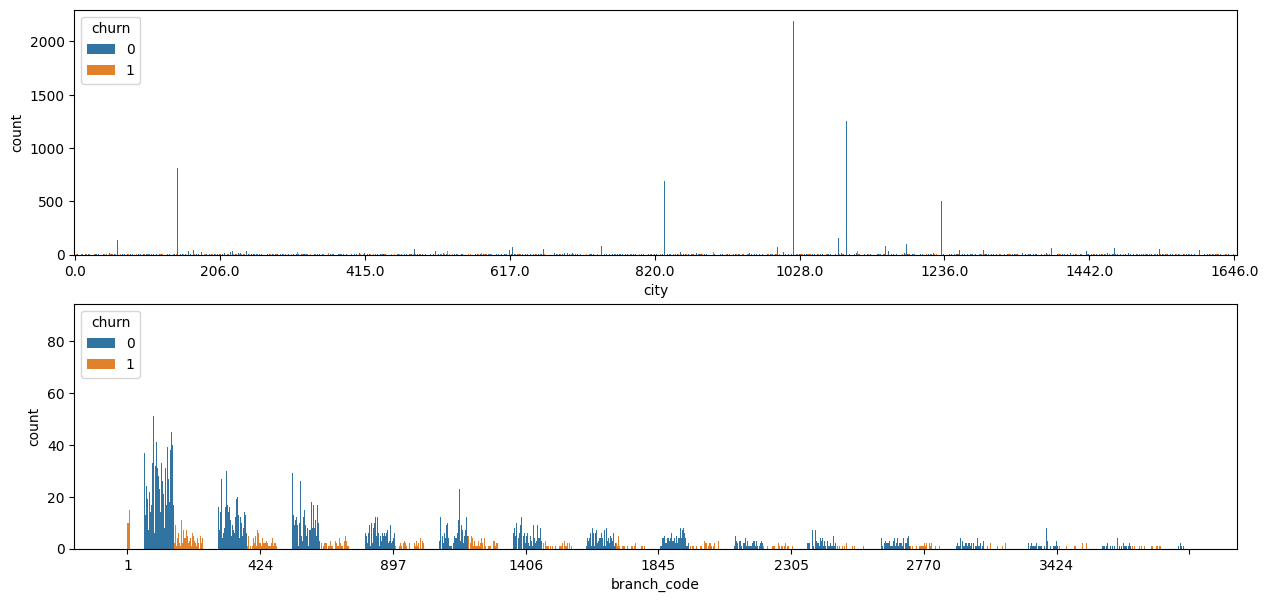

In [31]:
df_temp = deepcopy(df.sample(n = 2000, random_state = vars['params']['random_state']))

_, axes = plt.subplots(2, figsize = (15, 7))
sns.countplot(data = df, x = 'city', hue = 'churn', ax = axes[0])
axes[0].xaxis.set_major_locator(MaxNLocator(nbins = 10))
sns.countplot(data = df, x = 'branch_code', hue = 'churn', ax = axes[1])
axes[1].xaxis.set_major_locator(MaxNLocator(nbins = 10))
plt.plot()

del df_temp

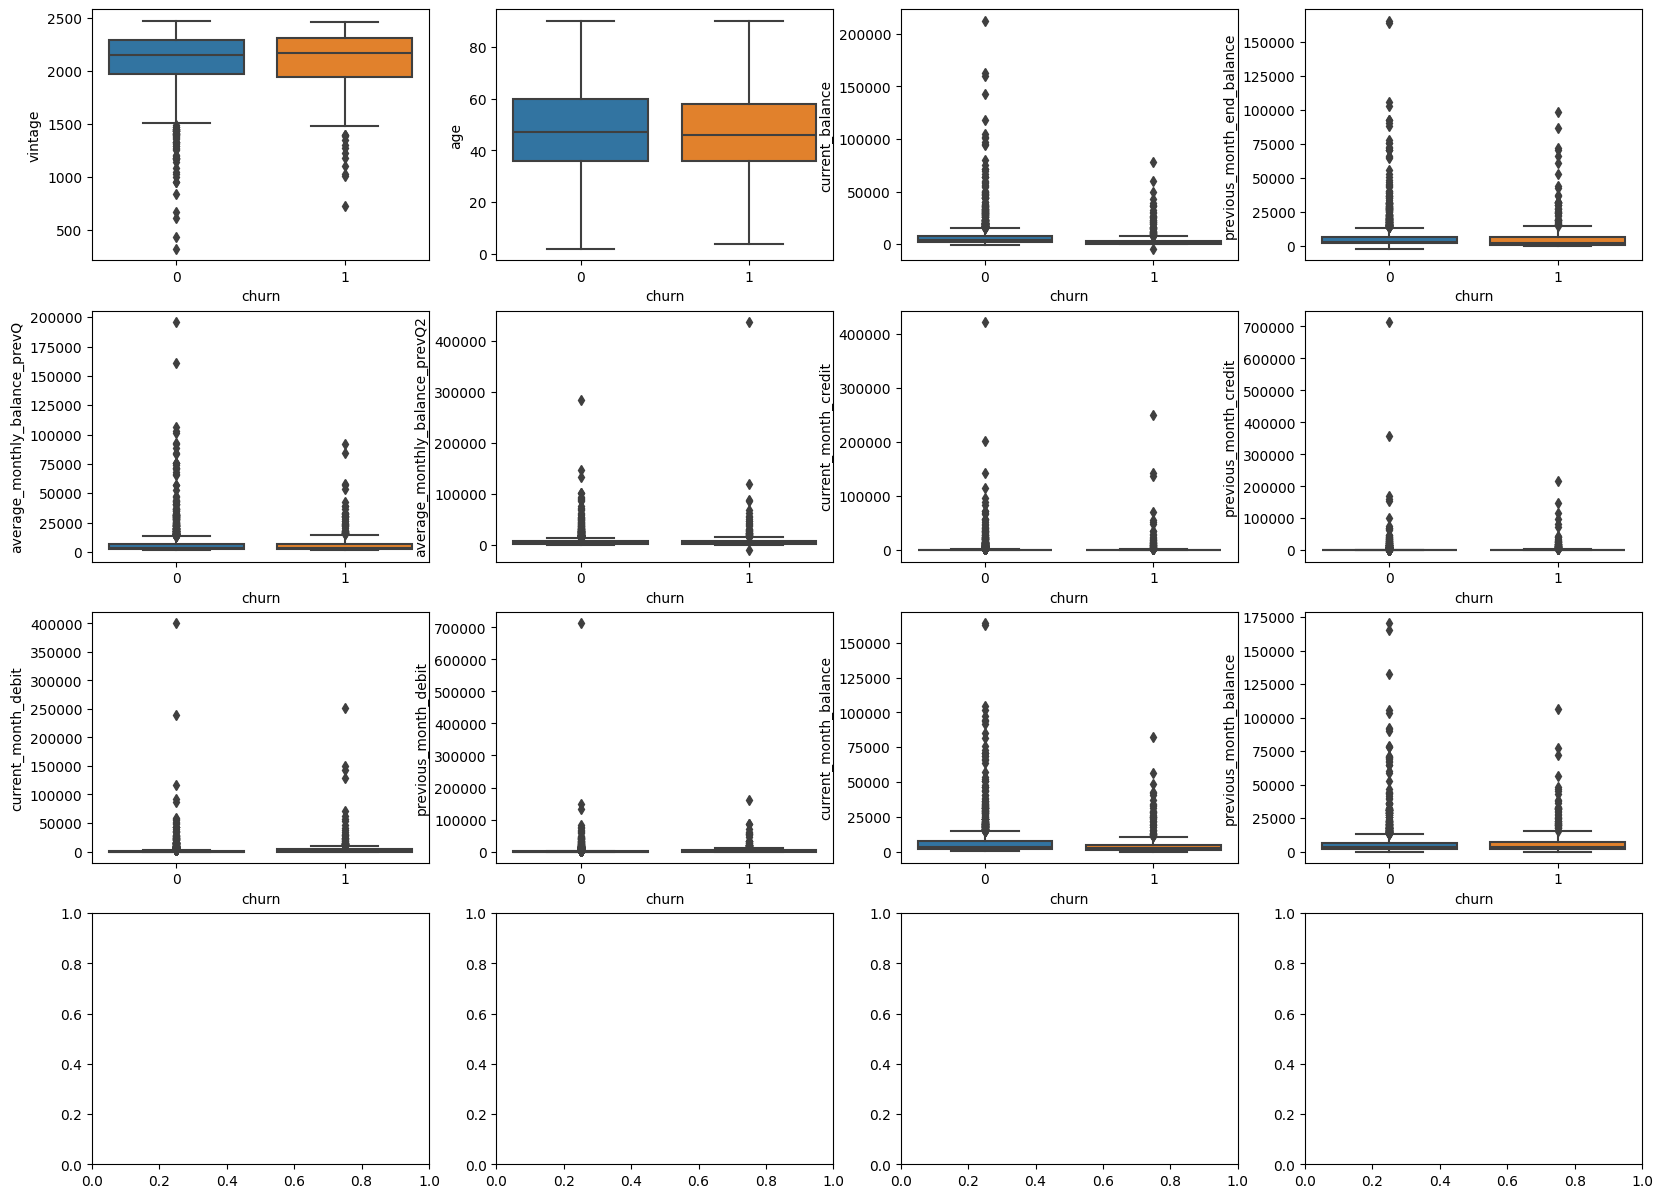

In [32]:
def vis_error(df: pd.DataFrame = df, samples: int = 2000) -> None:
    df_copy = deepcopy(df.sample(n = samples, random_state = vars['params']['random_state']))
    df_copy2 = pd.concat([df_copy.select_dtypes(include = 'number'), df_copy['churn']], axis = 1)
    
    _, axes = plt.subplots(4, 4, figsize = (20, 15))
    
    for col, ax in zip(df_copy2.drop(['churn'], axis = 1), axes.flatten()):
        sns.boxplot(df_copy2, y = col, x = 'churn', ax = ax)

    plt.show()
    
    del df_copy
    
vis_error()    

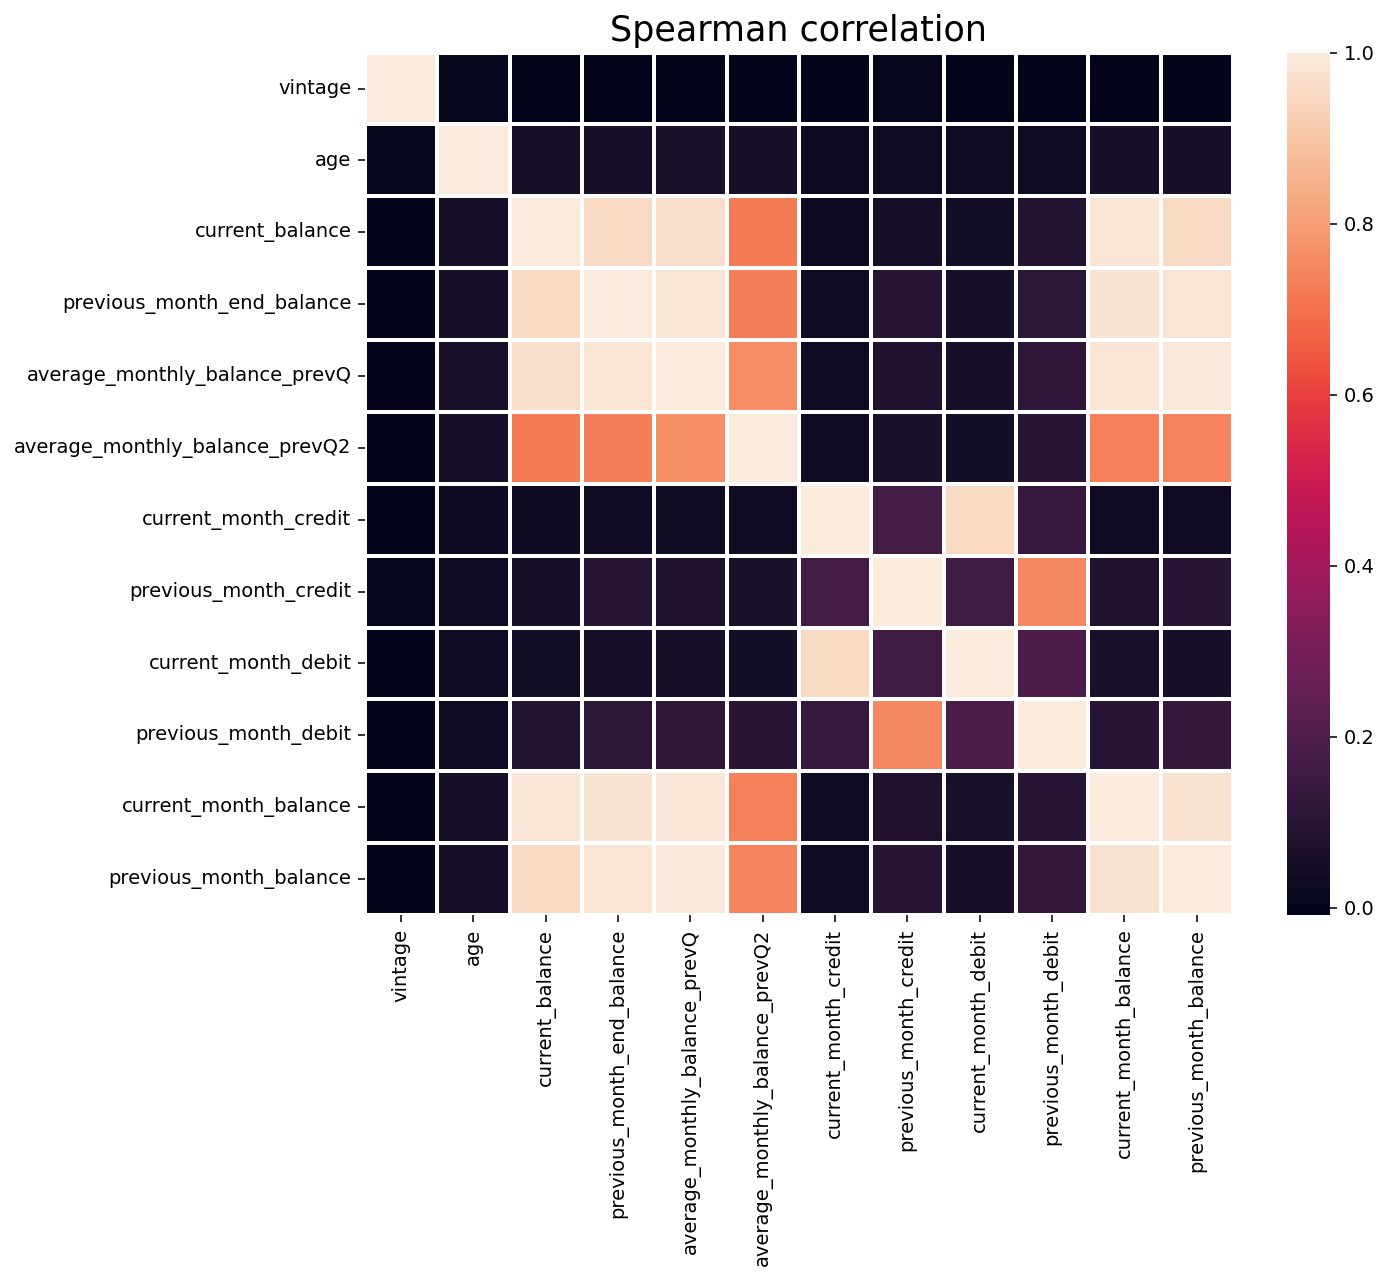

In [33]:
def vis_corr(df: pd.DataFrame = df) -> None:
    df_copy = deepcopy(df.select_dtypes(include = 'number'))
    
    plt.figure(figsize=(10, 8), dpi=140)
    correlation = df_copy.dropna().corr(method = 'pearson')
    sns.heatmap(correlation, linewidth = 2)
    plt.title('Spearman correlation', fontsize=18)
    

vis_corr()

Szybkie wnioski:
* Dane są niezbalansowane (zdecydowanie więcej jest przypadków, gdy **churn** = 0)
* Występują outliery. Trzeba je usunąć, bo modele drzewkowe będą zbyt próbowały się do nich dopasować co spowoduje overfitting
* Występują brakujące wartości
* Do niektórych danych kategorycznych potrzebne będzie zastosowanie encodingu (pominiemy **city** i **branch_code** ze względu na dużą ilość klas)
* Skalowanie danych nie powinno być konieczne (ponownie -- metody nie bazują na odległości między obserwacjami). Mimo tego zastosujemy **MinMaxScaler**

## 4. Preprocessing 2

In [34]:
basic_info(train_df)

,dtype,nunique,missing values
vintage,int64,1397,0.0%
age,int64,90,0.0%
gender,category,2,1.92%
dependents,category,15,8.84%
occupation,category,5,0.3%
city,category,1428,2.96%
customer_nw_category,category,3,0.0%
branch_code,category,3002,0.0%
current_balance,float64,21006,0.0%
previous_month_end_balance,float64,21033,0.0%


In [35]:
most_frequent_values = lambda col: df[col].value_counts(normalize=True) * 100

for col in ['gender', 'dependents', 'occupation', 'city']:
    print(most_frequent_values(col).head())
    print('\n')

gender
Male      59.43098
Female    40.56902
Name: proportion, dtype: float64


dependents
0.0    82.803401
2.0     8.085545
1.0     5.374903
3.0     2.829168
4.0     0.711157
Name: proportion, dtype: float64


occupation
self_employed    61.860334
salaried         23.640562
retired           7.280181
student           7.068137
company           0.150787
Name: proportion, dtype: float64


city
1020.0    12.858872
1096.0     7.286371
409.0      4.807553
146.0      4.744614
834.0      4.100702
Name: proportion, dtype: float64




**Brakujące wartości** -- obsłużymy braki w następujący sposób:
* Dane związane z datą usuniemy
* Gender, dependents, occupation i city uzupełnimy najczęściej występującymi wartościami

**Dane numeryczne** -- obsłużymy za pomocą MinMaxScaler

**Dane kategoryczne** -- wykorzystamy OneHotEncoder (oprócz kolumn city i branch_code)

**Korelacja** - usuniemy następujące kolumny ze względu na ich wysoką korelację z innymi:
* current_balance
* previous_month_end_balance
* average_monthly_balance_prevQ
* average_monthly_balance_prevQ2
* previous_month_debit

In [36]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.drop(self.columns, axis = 1)
        return X
    
    
def handle_nulls(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_fill = ['gender', 'dependents', 'occupation', 'city']
    cols_to_drop = ['year', 'month', 'day', 'weekday']
    # Fill nulls with most frequent values
    for col in cols_to_fill:
        df[col] = df[col].fillna(df[col].mode()[0])
    # Delete nulls in date data
    df = df.dropna(subset = cols_to_drop).reset_index(drop = True)
    return df


def scale_nums(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_scale = df.select_dtypes(include = 'number').columns.to_list()
    scaler = MinMaxScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df


def encode_cats(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_encode = df.select_dtypes(include = 'category').columns.to_list()
    cols_to_encode.remove('city')
    cols_to_encode.remove('branch_code')
    for column in cols_to_encode:
        if df[column].nunique() == 2:
            cols_to_encode.remove(column)
    df = pd.get_dummies(df, columns = cols_to_encode, prefix = cols_to_encode, prefix_sep = '_', drop_first = True).replace({True: 1, False: 0}).replace({'Female': 1, 'Male': 0})
    return df


def pipe_all(df: pd.DataFrame) -> pd.DataFrame:    
    pipeline = Pipeline([
        ('drop_columns', DropColumns(columns=['current_balance', 'previous_month_end_balance', 
                                            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
                                            'previous_month_debit'])),
        ('handle_nulls', FunctionTransformer(lambda X: handle_nulls(X), validate = False)),
        ('scale_nums', FunctionTransformer(lambda X: scale_nums(X), validate = False)),
        ('encode_cats', FunctionTransformer(lambda X: encode_cats(X), validate = False))
    ])
    df = pipeline.fit_transform(df)
    return df
    
    
train = pipe_all(train_df)
test = pipe_all(test_df)
display(train.head(2), test.head(2))

,vintage,age,gender,city,branch_code,current_month_credit,previous_month_credit,current_month_debit,current_month_balance,previous_month_balance,churn,dependents_1.0,dependents_2.0,dependents_3.0,dependents_4.0,dependents_5.0,dependents_6.0,dependents_7.0,dependents_8.0,dependents_9.0,dependents_25.0,dependents_32.0,dependents_36.0,dependents_50.0,dependents_52.0,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student,customer_nw_category_2,customer_nw_category_3,year_2019,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.711194,0.494382,1,797.0,1631,0.002911,0.000605,0.003610,0.003783,0.002252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.853933,0.370787,0,168.0,3395,0.000000,0.000000,0.000063,0.000773,0.001185,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


,vintage,age,gender,city,branch_code,current_month_credit,previous_month_credit,current_month_debit,current_month_balance,previous_month_balance,churn,dependents_1.0,dependents_2.0,dependents_3.0,dependents_4.0,dependents_5.0,dependents_6.0,dependents_7.0,dependents_8.0,dependents_9.0,dependents_25.0,dependents_32.0,dependents_36.0,dependents_50.0,dependents_52.0,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student,customer_nw_category_2,customer_nw_category_3,year_2019,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.942234,0.625,0,1458.0,1647,8.127367e-05,9.547822e-07,9.567893e-04,0.013514,0.003538,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.783055,1.000,0,513.0,216,3.570850e-07,1.134930e-06,3.570850e-07,0.010908,0.002465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## 5. Modelowanie

In [40]:
def get_features_and_target(df: pd.DataFrame) -> tuple[np.array, np.array]:
    X, y = np.array(df.drop(['churn'], axis = 1)), np.array(df['churn']).reshape(1, -1)[0]
    return X, y

X_train, y_train = get_features_and_target(train)
X_test, y_test = get_features_and_target(test)

### Random forest

In [109]:
model = RandomForestClassifier(n_estimators = 100, random_state = vars['params']['random_state'])
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print("\nClassification Report:\n", classification_rep)

Mean CV Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      5077
           1       0.51      0.07      0.13      1232

    accuracy                           0.81      6309
   macro avg       0.66      0.53      0.51      6309
weighted avg       0.75      0.81      0.74      6309



### Histogram-based gradient boosting

In [110]:
model = HistGradientBoostingClassifier(max_iter = 100, random_state = vars['params']['random_state'])
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print("\nClassification Report:\n", classification_rep)

Mean CV Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      5077
           1       0.53      0.08      0.14      1232

    accuracy                           0.81      6309
   macro avg       0.67      0.53      0.52      6309
weighted avg       0.76      0.81      0.74      6309



### XGBoost

In [111]:
# Wersja zwykła
model = xgb.XGBClassifier(n_estimators = 100, random_state = vars['params']['random_state'])
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print("\nClassification Report:\n", classification_rep)

Mean CV Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89      5077
           1       0.46      0.13      0.20      1232

    accuracy                           0.80      6309
   macro avg       0.64      0.54      0.54      6309
weighted avg       0.75      0.80      0.75      6309



### LightGBM

In [114]:
model = lgb.LGBMClassifier(n_estimators = 100, verbose = -1, random_state = vars['params']['random_state'])
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print("\nClassification Report:\n", classification_rep)

Mean CV Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      5077
           1       0.52      0.09      0.16      1232

    accuracy                           0.81      6309
   macro avg       0.67      0.54      0.52      6309
weighted avg       0.76      0.81      0.75      6309



### CatBoost

In [118]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)


model = CatBoostClassifier(iterations = 100, random_state = vars['params']['random_state'], verbose = False)
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)
model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print("\nClassification Report:\n", classification_rep)

Mean CV Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      5077
           1       0.47      0.11      0.18      1232

    accuracy                           0.80      6309
   macro avg       0.64      0.54      0.53      6309
weighted avg       0.75      0.80      0.75      6309



## 6. Optymalizacja hiperparametrów w XGBoost

In [124]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-5, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-5, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 30)
        param["eta"] = trial.suggest_loguniform("eta", 1e-5, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-5, 1.0)
        
    elif param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-5, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-5, 1.0)

    model = xgb.train(param, dtrain, evals = [(dtest, "validation")], verbose_eval = True)
    preds = model.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [130]:
study_name = 'example_study'
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, direction = 'maximize', load_if_exists = True)
study.optimize(objective, n_trials=100, show_progress_bar = True)
print(study.best_trial)

[I 2024-06-13 19:41:46,143] Using an existing study with name 'example_study' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[0]	validation-rmse:0.38837
[1]	validation-rmse:0.38430
[2]	validation-rmse:0.38788
[3]	validation-rmse:0.38570
[4]	validation-rmse:0.38484
[5]	validation-rmse:0.38539
[6]	validation-rmse:0.38480
[7]	validation-rmse:0.38460
[8]	validation-rmse:0.38391
[9]	validation-rmse:0.38427
[I 2024-06-13 19:41:46,839] Trial 100 finished with value: 0.8066254556982089 and parameters: {'monotone_0': 1, 'monotone_1': 0, 'monotone_2': 1, 'monotone_3': 0, 'monotone_4': 0, 'monotone_5': 0, 'monotone_6': 1, 'monotone_7': 0, 'monotone_8': 1, 'monotone_9': 0, 'monotone_10': -1, 'monotone_11': -1, 'monotone_12': 1, 'monotone_13': -1, 'monotone_14': 1, 'monotone_15': 1, 'monotone_16': 0, 'monotone_17': -1, 'monotone_18': -1, 'monotone_19': -1, 'monotone_20': 1, 'monotone_21': 0, 'monotone_22': 1, 'monotone_23': 1, 'monotone_24': -1, 'monotone_25': 0, 'monotone_26': 1, 'monotone_27': 1, 'monotone_28': -1, 'monotone_29': -1, 'monotone_30': 0, 'monotone_31': 0, 'monotone_32': 1, 'monotone_33': 1, 'monotone_34':

In [131]:
print("Best trial:")
best_trial = study.best_trial
print(best_trial.params)
print("Best accuracy:")
print(best_trial.value)

Best trial:
{'booster': 'dart', 'lambda': 1.014355491892528e-05, 'alpha': 0.02578270751999733, 'max_depth': 2, 'eta': 0.9987372272807412, 'gamma': 0.06785372126764289}
Best accuracy:
0.8090030115707719


In [100]:
!optuna-dashboard sqlite:///example_study.db

^C


In [132]:
best_params = study.best_params

final_model = xgb.XGBClassifier(**best_params, random_state = vars['params']['random_state'])

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89      5077
           1       0.48      0.15      0.23      1232

    accuracy                           0.80      6309
   macro avg       0.65      0.56      0.56      6309
weighted avg       0.76      0.80      0.76      6309



## 7. Ograniczenia monotoniczności w modelu XGBoost

### Ograniczenia monotoniczności

In [133]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)

    param = best_params
    for i in range(X_train.shape[1]):
        param[f'monotone_constraints{i}'] = trial.suggest_categorical(f"monotone_{i}", [-1, 0, 1])
    
    model = xgb.train(param, dtrain, evals = [(dtest, "validation")], verbose_eval = True)
    preds = model.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [134]:
study_name = 'monotone_constraint_study'
storage_name = f"sqlite:///{study_name}.db"
study_monotone = optuna.create_study(study_name=study_name, storage=storage_name, direction = 'maximize', load_if_exists = True)
study_monotone.optimize(objective, n_trials=100, show_progress_bar = True)
print(study_monotone.best_trial)

[I 2024-06-13 19:43:14,829] Using an existing study with name 'monotone_constraint_study' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[0]	validation-rmse:0.38777
[1]	validation-rmse:0.38818
[2]	validation-rmse:0.38732
[3]	validation-rmse:0.38589
[4]	validation-rmse:0.38429
[5]	validation-rmse:0.38346
[6]	validation-rmse:0.38183
[7]	validation-rmse:0.38240
[8]	validation-rmse:0.38362
[9]	validation-rmse:0.38363
[I 2024-06-13 19:43:16,496] Trial 100 finished with value: 0.8010778253288953 and parameters: {'monotone_0': -1, 'monotone_1': 1, 'monotone_2': 1, 'monotone_3': 0, 'monotone_4': -1, 'monotone_5': 1, 'monotone_6': -1, 'monotone_7': 1, 'monotone_8': -1, 'monotone_9': -1, 'monotone_10': -1, 'monotone_11': -1, 'monotone_12': -1, 'monotone_13': -1, 'monotone_14': -1, 'monotone_15': 0, 'monotone_16': -1, 'monotone_17': 0, 'monotone_18': -1, 'monotone_19': 1, 'monotone_20': 0, 'monotone_21': 0, 'monotone_22': -1, 'monotone_23': -1, 'monotone_24': 0, 'monotone_25': 1, 'monotone_26': -1, 'monotone_27': 0, 'monotone_28': 1, 'monotone_29': -1, 'monotone_30': 0, 'monotone_31': 0, 'monotone_32': 0, 'monotone_33': 1, 'monoto

In [135]:
print("Best trial:")
best_monotone_trial = study_monotone.best_trial
print(best_monotone_trial.params)
print("Best accuracy:")
print(best_monotone_trial.value)

Best trial:
{'monotone_0': -1, 'monotone_1': -1, 'monotone_2': 1, 'monotone_3': 1, 'monotone_4': 1, 'monotone_5': 1, 'monotone_6': 0, 'monotone_7': 1, 'monotone_8': 1, 'monotone_9': -1, 'monotone_10': 1, 'monotone_11': -1, 'monotone_12': -1, 'monotone_13': -1, 'monotone_14': 1, 'monotone_15': -1, 'monotone_16': 1, 'monotone_17': 1, 'monotone_18': 0, 'monotone_19': -1, 'monotone_20': 0, 'monotone_21': 1, 'monotone_22': -1, 'monotone_23': -1, 'monotone_24': 1, 'monotone_25': 0, 'monotone_26': 1, 'monotone_27': -1, 'monotone_28': 0, 'monotone_29': 0, 'monotone_30': -1, 'monotone_31': -1, 'monotone_32': -1, 'monotone_33': 1, 'monotone_34': 0, 'monotone_35': -1, 'monotone_36': 0, 'monotone_37': 1, 'monotone_38': 1, 'monotone_39': 1, 'monotone_40': -1, 'monotone_41': 0, 'monotone_42': 0, 'monotone_43': 1, 'monotone_44': 0, 'monotone_45': 1, 'monotone_46': 0, 'monotone_47': 0, 'monotone_48': 0, 'monotone_49': 1, 'monotone_50': 1, 'monotone_51': 0, 'monotone_52': -1, 'monotone_53': 1, 'monoton

In [ ]:
!optuna-dashboard sqlite:///monotone_constraint_study.db

In [136]:
best_monotone_params = study_monotone.best_params

monotone_model = xgb.XGBClassifier(**best_monotone_params, random_state = vars['params']['random_state'])

monotone_model.fit(X_train, y_train)
y_pred = monotone_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89      5077
           1       0.46      0.13      0.20      1232

    accuracy                           0.80      6309
   macro avg       0.64      0.54      0.54      6309
weighted avg       0.75      0.80      0.75      6309

